<b><font size="+3">Финальный проект для курса "Otus Data Science"</font></b>

<font size="+2">Этап B: Тестирование методов глубокого обучения с подкреплением
на примере задачи обратного маятника (openai gym cartpole) **С ВИДЕО ВВОДОМ**</font> 

# План исследования:
    Этап A. исследование методов обучения с подкреплением на простой модели (OpenAI Gym Cartpole)
    
    Этап В. Построение и оптимизация модели работающей с видео выходом (OpenAI Gym Racer)
    
    Этап С. Обучение модели для игры в простую настольную игру ("Connect Four")


# Experiments Setup

Сначала мы повторим функции, использованные для простой задачи Cartpole и протестируем их работоспособность:

### imports

In [5]:
import numpy as np
import random
import math
import time
import copy
from PIL import Image
from itertools import zip_longest
from collections import deque
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
Tensor = torch.Tensor
LongTensor = torch.LongTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Torch: {torch.__version__}, device: {device}")

Torch: 1.2.0, device: cuda


### GYM setup

In [7]:
# gym source code: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
import gym
env_id = 'CartPole-v0'
env = gym.make(env_id)

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

max_steps = 200 # get_from Gym
score_to_solve = max_steps - 5

### Epsilon function

0.3742006467597279 0.010044945930464861


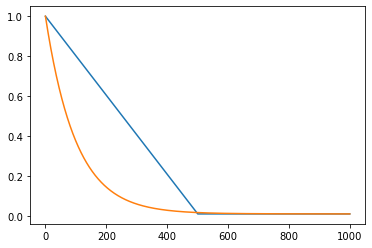

In [8]:
def get_epsilon(step, params=None):
    """Epsilon adjustment function (exponential)"""
    if params is None:
        params = {'start': 1, 'end': 0.01, 'decay': 100}  # <= defaults
    return params['end'] + (params['start']-params['end']) * \
        math.exp(-1. * step / params['decay'])

def get_epsilon_linear(step, params=None):
    """ Epsilon adjustment function (linear)"""
    if params is None:
        params = {'start': 1, 'end': 0.01, 'period': 500}  # <= defaults
    return params['start'] - min(params['period'], step) * \
        (params['start']-params['end']) / params['period'] 
    
plt.plot([get_epsilon_linear(s, None) for s in range (1000)])
plt.plot([get_epsilon(s, None) for s in range (1000)])

print(get_epsilon(100), get_epsilon(1000))

### plotting functions

In [9]:
def moving_average(x, w):
    """ moving average with accurate tail"""
    s = np.cumsum([0] + x)
    r = []
    for i in range(len(x)):
        j = min(len(x), i+w)
        r.append((s[j]-s[i])/(j-i))
    return r


def plot_history(history):
    """ plots scores progress from single learning history"""
    plt.figure(figsize=(12, 4))
    plt.plot(history['score'])
    plt.title(f"Learning performance by '{agent.history['name']} (score per episode)'",
              fontsize=18)
#     plt.xlabel('episodes')
    plt.ylabel('score')


def plot_running_avg(series, window=20, show_range=None):
    if not isinstance(series, np.ndarray):
        series = np.array(series)
    N = len(series)
    if show_range is None:
        show_range = (0, N)
    running_avg = np.empty(N)
    for t in range(show_range[0], show_range[1]):
        running_avg[t] = series[max(0, t-window):(t+1)].mean()

    plt.figure(figsize=(16, 4))
    plt.plot(running_avg)
    plt.yticks([0, 50, 100, 150, 200])
    plt.grid()
    plt.title("Running Average")

    plt.show()


def plot_compare(histories, title, smoothing=10):
    """ plots with data from multiple learning histories"""

    fig = plt.figure(constrained_layout=True, figsize=(18, 4))
    fig.suptitle(title, fontsize=20, y=1.04)

    gs = fig.add_gridspec(1, 5)
    axs = [fig.add_subplot(gs[:3]),
           fig.add_subplot(gs[3]),
           fig.add_subplot(gs[4]), ]

    colors = ['r', 'g', 'b', 'c', 'm', 'orange', 'purple', 'black', 'teal',
              'r', 'g', 'b', 'c', 'm', 'orange', 'purple', 'black', 'teal', ]

    names = [h['name'] for h in histories]
    scores = np.array([h['score'] for h in histories])

    for ax in axs:
        ax.grid()

    axs[0].set_title(f'Score progress', fontsize=16)
    for i in range(len(histories)):
        score_to_plot = moving_average(scores[i], smoothing)
        axs[0].plot(score_to_plot, '-', lw=2, label=names[i], color=colors[i])
    axs[0].set(xlabel='episodes')
    axs[0].legend(fontsize=14)

    axs[1].set_title(f'Episodes', fontsize=16)
    axs[1].bar(names, [h['episodes'] for h in histories], color=colors)

    axs[2].set_title(f'Time elapsed', fontsize=16)
    axs[2].bar(names, [h['elapsed_time'] for h in histories], color=colors)

### memory

In [10]:
replay_mem_size = 10000

class ReplayMemory(object):
    """ basic memry class from Torch example """
    def __init__(self, capacity=replay_mem_size):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)

        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition

        self.position = (self.position + 1) % self.capacity

    def push_batch (self, batch):
        for state, action, new_state, reward, done in batch:
            self.push (state, action, new_state, reward, done)
            
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def reset (self):
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)

class ReplayMemory3(ReplayMemory):
    """ variant with separate list of keys for deduplication"""
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.keys=[]
        self.position = 0

    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)

        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def reset (self):
        self.memory = []
        self.position = 0


class ReplayMemory4():
    """ Uses separate memories for positive and negative experiences """
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.positives = ReplayMemory3(capacity=capacity//2)
        self.negatives = ReplayMemory3(capacity=capacity//2)

    def push_batch (self, batch):
        posi_batch = [b for b in batch if b[3]>0.9]
        nega_batch = [b for b in batch if b[3]<=0.9]
        self.positives.push_batch(posi_batch)
        self.negatives.push_batch(nega_batch)
    
    def push(self, state, action, new_state, reward, done):
        raise NotimplementedError
        
    def sample(self, batch_size):
        posi_size = min (len(self.positives), batch_size//2)
        nega_size = min (len(self.negatives), batch_size - posi_size)
        if nega_size < batch_size //2:
            posi_size = batch_size - nega_size
        posi_sample = list(self.positives.sample(posi_size))
        nega_sample = list(self.negatives.sample(nega_size))
        return [p+n for p, n in zip_longest (posi_sample, nega_sample)]
    
    def reset (self):
        self.positives.reset()
        self.negatives.reset()
                
    def __len__(self):
        return min(self.positives.__len__(), self.negatives.__len__())*2

### Neural Networks

In [11]:
""" NEURAL NETWORKS """
activations = {'relu': nn.ReLU, 'tanh': nn.Tanh}

class NeuralNetwork(nn.Module):
    """
    NN class with FC layers only
    :param hidden: iterable of FC layer sizes
    """
    def __init__(self, hidden, inputs=number_of_inputs, outputs=number_of_outputs, 
                 activation='relu'):
        super(NeuralNetwork, self).__init__()
        layers = [inputs] + hidden + [outputs]
        layers_number = len(layers) - 1
        self.fc_list= nn.ModuleList()
        for i in range (layers_number):
            self.fc_list.append(nn.Linear(layers[i],layers[i+1]))

        self.activation = activations[activation]()

    def forward(self, x):
        out = self.fc_list[0](x)
        for i in range (1, self.fc_list.__len__()):
            out = self.activation(out)
            out = self.fc_list[i](out)
        return out

class NeuralNetwork_Dueling(nn.Module):
    """ Dualing NN based on Udemy example """
    def __init__(self, hidden=32, inputs=number_of_inputs, outputs=number_of_outputs, 
                 activation='relu'):
        super(NeuralNetwork_Dueling, self).__init__()
        self.linear1 = nn.Linear(inputs,hidden)
        self.advantage = nn.Linear(hidden, outputs)
        self.value = nn.Linear(hidden, 1)
        self.activation = activations[activation]()

    def forward(self, x):
        out1 = self.linear1(x)
        out1 = self.activation(out1)       
        out_adv = self.advantage(out1)
        out_val = self.value(out1)
        out = out_val + out_adv - out_adv.mean()
        return out  

### Learning agent

In [12]:
class Agent_DQN(object):
    """
    Learning agent class. Contains NN and functions to use and optimize it
    """
    def __init__(self, name, net, optimizer="adam", lr=0.01, batch_size=32,
                 double_dqn=False, clip_error=True, update_target_frequency=10,
                 gamma=0.9999, loss_func='smooth_l1'):
        """
        :param str name: text for unique representation of the agent
        :param net: Torch NN for deep learning. 
        :param optimizer: Optimizer type for NN ('adam'/'sgd'/'rmsprop')
        :param lr: Learning Rate
        :param batch size: 
        :param double_dqn: uses Double Deep Q network architecture
        :param clip_error: limits gradient error to [-1:1] range
        :param update_target_frequency: number of optimizer call between target NN updates
        :param gamma: discount factor for future rewards 
        :param loss_func: Loss function ('mse'/'smooth_l1')        
        """
        self.name = name
        self.double_dqn = double_dqn
        self.clip_error = clip_error
        self.batch_size = batch_size
        self.update_target_frequency = update_target_frequency
        self.gamma = gamma

        self.memory = ReplayMemory4()
        self.history = {'name': self.name, 'score': []}

        self.nn = net.to(device)
        self.target_nn = copy.deepcopy(self.nn).to(device)

        loss_functions = {'mse': nn.MSELoss, 'smooth_l1': nn.SmoothL1Loss}
        self.loss_func = loss_functions[loss_func]()

        if optimizer == 'sgd':
            self.optimizer = optim.SGD(
                params=self.nn.parameters(), lr=lr, momentum=0.9)
        elif optimizer == 'rmsprop':
            self.optimizer = optim.RMSprop(params=self.nn.parameters(), lr=lr)
        else:
            self.optimizer = optim.Adam(params=self.nn.parameters(), lr=lr)

        self.update_target_counter = 0
        self.reset()
    
    @staticmethod
    def weight_reset(m):
        """resets NN weights for FC and Conv layers """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            m.reset_parameters()

    def reset(self):
        """resets NN, memory and history between experiments"""
        self.nn.apply(self.weight_reset)
        self.update_target_net()
        self.memory.reset()
        self.history = {'name': self.name, 'score': []}
        self.update_target_counter = 0

    def transform_state(self, state):
        """transforms gym state output to torch tensor for NN use"""
        if not isinstance (state, torch.Tensor):
            state = torch.Tensor(state)
        return state.unsqueeze(0).to(device)

    def select_action(self, state, epsilon):
        if torch.rand(1)[0] > epsilon:
            with torch.no_grad():  # do we need this?
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn, -1).indices.item()
        else:
            action = env.action_space.sample()
        return action

    def optimize(self, verbose=False, batch_size=None):
        """wrapper for optimization routine
        handles batch size choice and empty memory situations"""
        if batch_size is None:
            batch_size = self.batch_size
        if len(self.memory) < batch_size:
            return
        sample = self.memory.sample(batch_size)
        self.optimize_engine(sample, verbose)

    def optimize_engine(self, sample, verbose=False):
        """ optimization routine
        optimizes self.nn weights based on 1 run of sample batch
        sample: tuple (state, action, new_state, reward, done)
        sample dimensions = (batch_size, state dimension(s))
        """
        state, action, new_state, reward, done = sample
        state_batch = torch.cat(state).to(device)
        new_state = torch.cat(new_state).to(device)
        reward_batch = torch.cat(reward).to(device)

        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)

        if self.double_dqn:  # idea from Udemy course
            new_state_indexes = self.nn(new_state).detach()
            max_new_state_indexes = torch.max(new_state_indexes, 1)[1]

            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = new_state_values.gather(
                1, max_new_state_indexes.unsqueeze(1)).squeeze(1)
        else:
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values, 1)[0]

        target_value = reward_batch + \
            (1 - done) * self.gamma * max_new_state_values  # Bellman Equation
        predicted_value = self.nn(state_batch).gather(
            1, action.unsqueeze(1)).squeeze(1)

        loss = self.loss_func(predicted_value, target_value)
        
        self.optimizer.zero_grad()
        loss.backward()

        if self.clip_error:  # limit error - idea from Deepmind’s paper:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

        if self.update_target_counter % self.update_target_frequency == 0:
            self.update_target_net()

        self.update_target_counter += 1

    def update_target_net(self):
        """copies policy NN weights to target NN"""
        self.target_nn.load_state_dict(self.nn.state_dict())
        
        
# class Agent_DQN_2 (Agent_DQN):
#     """ uses different transformation for video inputs """
#     def transform_state(self, state):
#         return state.unsqueeze(0).to(device)

### LAB for experiments

In [13]:
# Functions to transform rewards given by the gym to penalize last steps before agent failure

def transform_run_history(run_history):
    """ исправляет историю перед отправкой в память
    добавляет отрицательные награды в последние шаги перед падением
    если история короче максимума"""
    loss_score = -1.0
    if len (run_history) < max_steps:
        run_history[-1][3] *= loss_score
        run_history[-2][3] *= loss_score / 2.0
        run_history[-3][3] *= loss_score / 4.0
        run_history[-4][3] *= 0
        run_history[-5][3] *= 0
        run_history[-6][3] *= 0
        run_history[-7][3] *= 0
    return run_history

def transform_run_history_01(run_history): # OLDER VERSION
    """ исправляет историю перед отправкой в память
    добавляет отрицательные награды в последние шаги перед падением
    если история короче максимума"""
    loss_score = -1.0
    if len (run_history) < max_steps:
        run_history[-1][3] *= loss_score
        run_history[-2][3] *= loss_score / 2.0
        run_history[-3][3] *= 0
    return run_history

In [14]:
class Lab(object):
    """ 
    запускает тесты в Open.ai gym environment 
    в режимах обучения и тестирования
    """

    def __init__(self, env=gym.make('CartPole-v0')):
        self.env = env
        self.max_steps = 200

    def test(self, agent, episodes=5, min_score=195, max_steps=200, verbose=0):
        """
        Runs multiple episodes to chech whether agent can reach target score
        """
        start_time = time.time()
        for i_episode in range(episodes):
            result, _ = self.run_episode(agent, training=False)
            if verbose > 0:
                print(f" test:{i_episode}, score:{result}")
            elapsed_time = time.time() - start_time  # to be used

            if result < min_score:
                if verbose > 0:
                    print("TEST FAILED...")
                return False
        if verbose > 0:
            print("TEST PASSED !")
        return True

    def train(self, agent, max_episodes=1000,  verbose=0,  epsilon_params=None,
              report_interval=10, ):
        """
        Runs multiple episodes to chech whether agent can reach target score
        :param agent: Agent to be trained
        :param max_episodes:
        :param verbose: 0=none, 1, 2
        :param epsilon_params: tuple of 3 numbers for epsilon function 
        :param report_interval: episodes between brief reports (if verbose > 0)
        """
        if verbose > 0:
            print(
                f"Training for agent '{agent.name}', max_episodes:{max_episodes}")
        start_time = time.time()  # for overal traininig time
        train_time = 0
        solved = False

        for i_episode in range(1, max_episodes+1):
            epsilon = get_epsilon(i_episode, epsilon_params)

            result, run_history = self.run_episode(
                agent, training=True, epsilon=epsilon)

            elapsed_time = time.time() - start_time

            run_history = transform_run_history(run_history)
            agent.memory.push_batch(run_history)

            agent.history['score'].append(result)
            if i_episode % report_interval == 0 and verbose >= 2:
                print(f"Episode {i_episode}: "
                      f"Last {report_interval} average: {sum(agent.history['score'][-report_interval:])/report_interval:.1f}; "
                      f"Eps: {epsilon:.3f}, "
                      "Elapsed:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

            if not solved and result >= score_to_solve:  # test if solved
                if self.test(agent):  # if test returns True
                    if verbose >= 1:
                        print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
                    break
        agent.history['elapsed_time'] = elapsed_time
        agent.history['episodes'] = i_episode

        if verbose >= 1:
            print(
                f"Elapsed {elapsed_time:.2f}s, per episode:{elapsed_time/i_episode:.2f}s, ")

    def run_episode(self, agent, training=False, epsilon=0, verbose=1):
        """
        runs single episode of gym with Agent
        calls NN optimization function in training mode
        """
        state = self.env.reset()
        state = agent.transform_state(state)
        run_history = []
        counter = 0
        done = False

        for step in range(1, self.max_steps+1):  # and counter < max_steps:
            action = agent.select_action(state, epsilon)

            new_state, reward, done, info = self.env.step(action)
            new_state = agent.transform_state(new_state)

            if training:
                if done and step < 190:
                    reward = -1.0  # tweak to add negative reward
                reward = torch.tensor([reward], device=device)
                agent.optimize()
                run_history.append([state, action, new_state, reward, done])
            state = new_state

            if done:
                break
                
        return step, run_history

### Тестирование модели

In [15]:
# non-visual models are faster with CPU (3-4 x)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [16]:
lab = Lab()

agent = Agent_DQN(name="test_agent", net=NeuralNetwork([32],),
                  optimizer="adam", lr=0.01, double_dqn=False, update_target_frequency=500)

e_params = {'start': 1, 'end': 0.01, 'decay': 50}
lab.train(agent, max_episodes=300, verbose=2, epsilon_params=e_params)

Training for agent 'test_agent', max_episodes:300
Episode 10: Last 10 average: 26.5; Eps: 0.821, Elapsed: 00:00:00
Episode 20: Last 10 average: 29.8; Eps: 0.674, Elapsed: 00:00:00
Episode 30: Last 10 average: 61.0; Eps: 0.553, Elapsed: 00:00:01
SOLVED! After 31 episodes 
Elapsed 1.48s, per episode:0.05s, 


In [21]:
# ms per step
agent.history['elapsed_time'] / sum(agent.history['score']) * 1000

1.2017288531973611

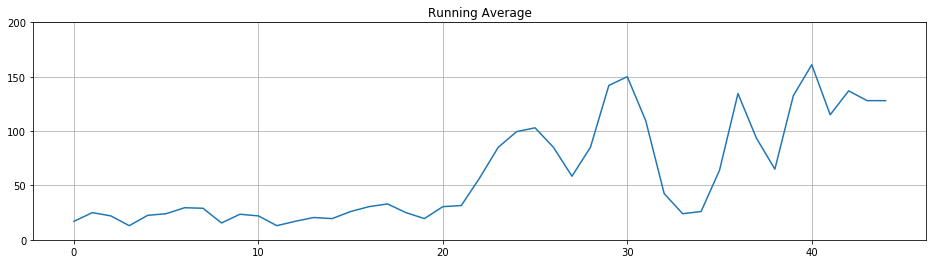

In [22]:
plot_running_avg(agent.history['score'], window = 1)

In [23]:
lab.test(agent, episodes=5, min_score=195, max_steps=200, verbose=1)

 test:0, score:200
 test:1, score:200
 test:2, score:200
 test:3, score:200
 test:4, score:200
TEST PASSED !


True

In [ ]:
assert False, 'Stopper to save Notebook from re-runs'

In [3]:
a=1
b = torch.Tensor([a])
a, b


(1, tensor([1.]))

In [5]:
isinstance (b, torch.Tensor)

True

In [2]:
import torch

# Обучение с подкреплением на основе визуальной информации

Далее решаем задачу Cartpole с обучением сети только на основе визуальной информации. 

**Основа:**

За основу я пытался взять код из примера https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html но он не давал положительного результата, поэтому потребовалось провестиряд модификаций описанных ниже:

- раздельная память
- ввод трёх кадров подряд вместо разности двух
- более мощная нейросеть
- подбор гиперпараметров


**Изменения в сравнении с простой задачей:**

Для решения используем агента и Lab от простой задачи и меняем только следующее:
- добавляем wrapper для Gym Environment, который будет передавать состояние Environment в виде видео кадров
- используем более мощные нейросети со слоями свёртки
- используем немного иные гиперпараметры

In [21]:
# use GPU. Cuda on GTX-1080 runs 6x faster than Ryzen 2700x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

### Получение кадра и wrapper

Text(0.5, 1.0, 'Example extracted screen')

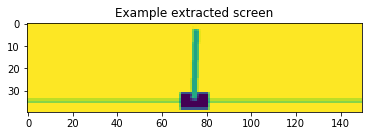

In [22]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen(env):
    """
    takes gym screen render, converts to grayscale and scales downreduces 
    """
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))

    screen = np.sum(screen, axis=0)/3  # to grayscale

    screen_height, screen_width = screen.shape
    screen = screen[int(screen_height*0.4):int(screen_height * 0.8), :] # cut edges

    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = resize(screen).to(device)
    return screen


env.reset()
plt.figure()
scr = get_screen(env).cpu().squeeze(0).numpy()
plt.imshow(scr,
           interpolation='none')
plt.title('Example extracted screen')
# plt.show()

In [23]:
class FrameStack():  
    """
    Wrapper for video output from Cartpole Gym
    delivers k latest frames stacked
    
    based on https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py
    """
    def __init__(self, env, k=3):
        self.k = k
        self.frames = deque([], maxlen=k)
        self.env = env

    def reset(self):
        state = self.env.reset()
        frame = get_screen(self.env)
        for _ in range(self.k):
            self.frames.append(frame)
        return self._get_ob()

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        frame = get_screen(self.env)
        self.frames.append(frame)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return torch.cat(list(self.frames))

class FrameStack_diff(FrameStack): 
    """
    returns last frame and deltas with 2 preceding frames
    """
    def _get_ob(self):
        output = [self.frames[-1], self.frames[-1]-self.frames[-2]]
        return torch.cat(output)

In [24]:
### тестировались три различных обёртки
env2 = FrameStack_diff(env, 2)  # соответствует коду из примера на Torch
env3 = FrameStack(env, 3)
env4 = FrameStack(env, 4)

### testing FrameStack wrapper

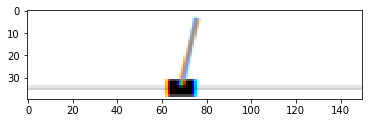

In [26]:
_ = env3.reset()

for i in range (10):
    s, reward, done, _ = env3.step(0)

plt.imshow(s.cpu().permute(1, 2, 0).numpy())

### Networks for visual input

In [27]:
class DQN_V_1(nn.Module):
    """ Сеть из примера PyTorch """

    def __init__(self, h, w, outputs):
        super(DQN_V_1, self).__init__()
        self.conv1 = nn.Conv2d(screen_channels, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

class DQN_V_1b(nn.Module):
    """ То же, с добавлением второго полносвязного слоя """

    def __init__(self, h, w, outputs, channels=3):
        super(DQN_V_1b, self).__init__()
        self.conv1 = nn.Conv2d(channels, 96, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.fc4 = nn.Linear(linear_input_size, 42)  # extra FC layer
        self.fc5 = nn.Linear(42,2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        return self.fc5(x)
    

class DQN_V_1c(DQN_V_1b):
    """ Усиленный вариант со сниженным шагом пераого сверточного слоя (stride=1)"""
    def __init__(self, h, w, outputs, channels=3):
        super(DQN_V_1c, self).__init__(h, w, outputs, channels)
        self.conv1 = nn.Conv2d(channels, 96, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        linear_input_size = 6528  # число рассчитано по формуле из родительского класа
        self.fc4 = nn.Linear(linear_input_size, 42)  # extra FC layer
        self.fc5 = nn.Linear(42,2)

### Video input experiments

In [ ]:
# training example for demo
lab_video = Lab(env=env3)
screen = lab_video.env.reset()
screen_channels, screen_height, screen_width = screen.shape

net_v1c2 = DQN_V_1c(screen_height, screen_width, number_of_outputs, screen_channels)

agent_v8 = Agent_DQN(name="video_agent", net=net_v1c2, 
                  optimizer="sgd", lr=0.01, double_dqn=False, update_target_frequency = 1000)

e_params = {'start': 1, 'end': 0.01, 'decay': 100}
lab_video.train(agent_v8, max_episodes=3000, verbose=2, epsilon_params = e_params,
                report_interval = 20)

In [ ]:
plot_running_avg(agent_v8.history['score'], window = 30)

In [ ]:
lab_video.test(agent_v8, episodes=5, min_score=100, max_steps=200, verbose=1)

In [28]:
lab_video = Lab(env=env3)
screen = lab_video.env.reset()
screen_channels, screen_height, screen_width = screen.shape
DQN_V_1c(screen_height, screen_width, number_of_outputs, screen_channels)

DQN_V_1c(
  (conv1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=6528, out_features=42, bias=True)
  (fc5): Linear(in_features=42, out_features=2, bias=True)
)

### успешное решение
Подбором было найдено сочетание структуры сети и гиперпараметров, которые давали решение задачи за 800-1000 итераций (сравните с 30-50 для оптимизирванных решений простого варианта Cartpole)
Учитывая длительность экспериментов, широкий поиск более оптимальных решений провести не удалось. Я ограничился тестированием выбора обёртки, мощности сети, размера подвыборки.

In [31]:
lab_video = Lab(env=env3)
screen = lab_video.env.reset()
screen_channels, screen_height, screen_width = screen.shape

net_v1c = DQN_V_1c(screen_height, screen_width, number_of_outputs, screen_channels)

agent_v7 = Agent_DQN(name="video_agent", net=net_v1c, 
                  optimizer="adam", lr=0.01, double_dqn=False, update_target_frequency = 1000)

e_params = {'start': 1, 'end': 0.01, 'decay': 100}

lab_video.train(agent_v7, max_episodes=3000, verbose=2, epsilon_params = e_params,
                report_interval = 20)

Training for agent 'video_agent', max_episodes:3000
Episode 20: Last 20 average: 26.2; Eps: 0.821, Elapsed: 00:00:14
Episode 40: Last 20 average: 25.1; Eps: 0.674, Elapsed: 00:00:30
Episode 60: Last 20 average: 23.2; Eps: 0.553, Elapsed: 00:00:45
Episode 80: Last 20 average: 26.7; Eps: 0.455, Elapsed: 00:01:02
Episode 100: Last 20 average: 24.9; Eps: 0.374, Elapsed: 00:01:19
Episode 120: Last 20 average: 29.1; Eps: 0.308, Elapsed: 00:01:38
Episode 140: Last 20 average: 27.8; Eps: 0.254, Elapsed: 00:01:57
Episode 160: Last 20 average: 28.6; Eps: 0.210, Elapsed: 00:02:17
Episode 180: Last 20 average: 35.6; Eps: 0.174, Elapsed: 00:02:42
Episode 200: Last 20 average: 35.1; Eps: 0.144, Elapsed: 00:03:06
Episode 220: Last 20 average: 47.2; Eps: 0.120, Elapsed: 00:03:39
Episode 240: Last 20 average: 41.7; Eps: 0.100, Elapsed: 00:04:08
Episode 260: Last 20 average: 43.0; Eps: 0.084, Elapsed: 00:04:39
Episode 280: Last 20 average: 49.5; Eps: 0.070, Elapsed: 00:05:14
Episode 300: Last 20 average

График показывает сглаженные значения. После 815 шагов обучения данный агент смог 5 раз подряд продержать маятник в течение 200 шагов.

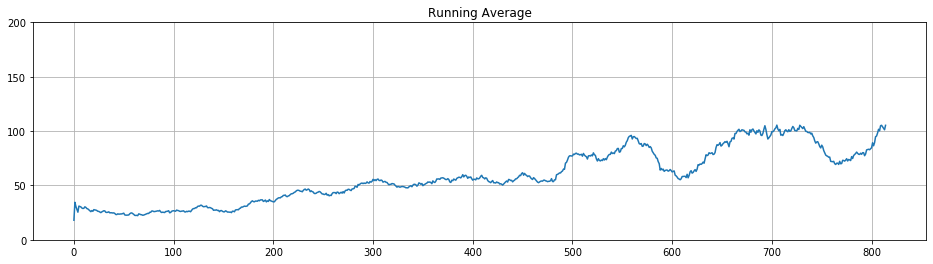

In [32]:
plot_running_avg(agent_v7.history['score'], window = 30)

real life examples:

https://youtu.be/XiigTGKZfks

https://www.youtube.com/watch?v=meMWfva-Jio